# Project 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [17]:
# 1a: Load data
count_df = pd.read_csv('data/single_cell_count_matrix.txt', sep='\t', index_col=0)
gene_annot = pd.read_csv('data/gene_name.txt', sep='\t')  # columns: gene_name, Ensembl IDs

# Display basic info
print("The size of the dataframe is (genes x samples):", count_df.shape)
display("First 5 genes and first 5 samples:", count_df.iloc[:5, :5])

The size of the dataframe is (genes x samples): (21783, 54)


'First 5 genes and first 5 samples:'

,cell_1,cell_2,cell_3,cell_4,cell_5
Ensembl IDs,,,,,
ENSMUSG00000085214,0,0,0,0,0
ENSMUSG00000090401,1,0,0,0,0
ENSMUSG00000021252,1548,0,0,2,4
ENSMUSG00000007777,5685,0,537,0,7360
ENSMUSG00000043644,0,0,0,0,0


In [ ]:
# 1b: Check data types
print("Data types: ", count_df.dtypes.unique())
# its raw

Data types:  [dtype('int64')]


Filtered DataFrame shape: (18238, 54)
Max/Min library size ratio: 11.37574860723115


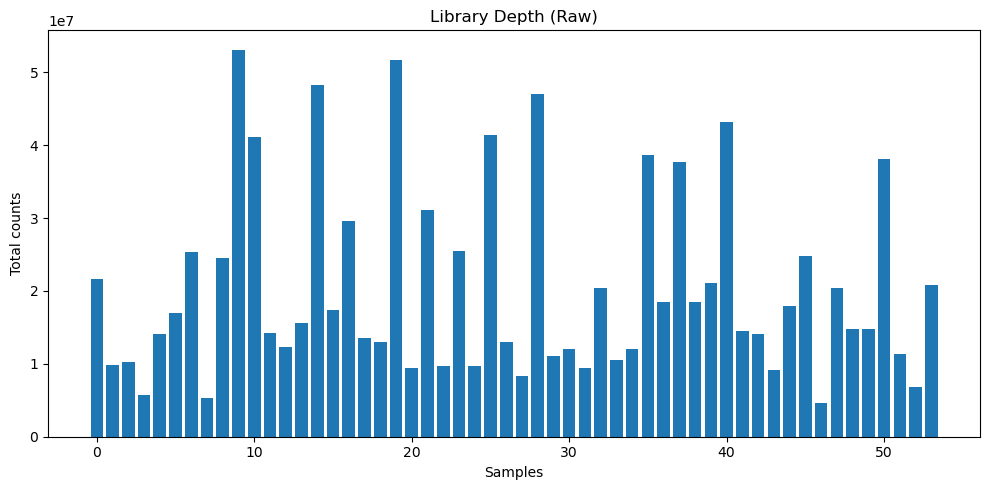

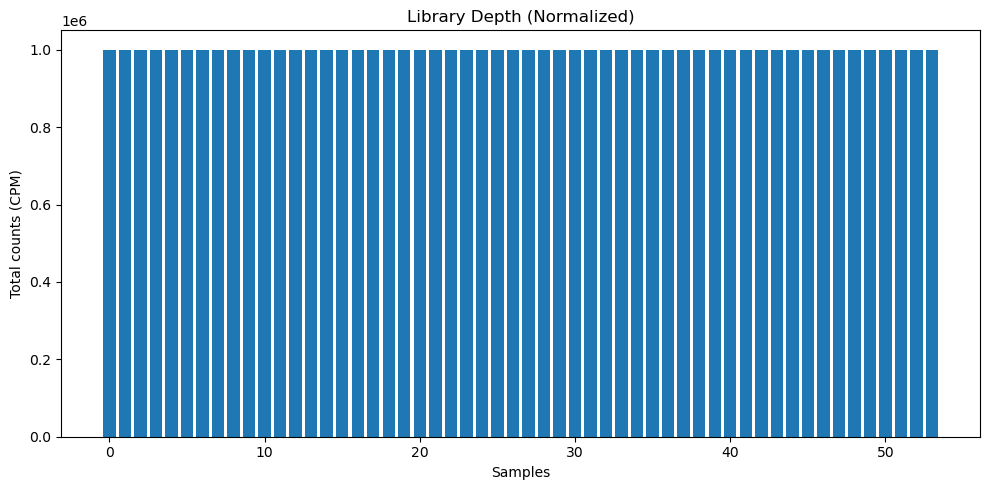

In [28]:
# 1c: Filter genes not expressed
# Filter genes not expressed
non_zero_mask = (count_df.sum(axis=1) > 0)
filtered_df = count_df.loc[non_zero_mask]
print("Filtered DataFrame shape:", filtered_df.shape)

# Check library depth variation
lib_sizes_raw = filtered_df.sum(axis=0)  # Raw library sizes
lib_depth_variation = lib_sizes_raw.max() / lib_sizes_raw.min()
print("Max/Min library size ratio:", lib_depth_variation)
need_normalization = lib_depth_variation > 1.2

# Normalize if needed (CPM)
if need_normalization:
    cpm_df = filtered_df.div(lib_sizes_raw, axis=1) * 1e6
else:
    cpm_df = filtered_df.copy()

lib_sizes_cpm = cpm_df.sum(axis=0)  # Normalized library sizes

# Plot raw library sizes
plt.figure(figsize=(10, 5))
plt.bar(range(lib_sizes_raw.shape[0]), lib_sizes_raw)
plt.xlabel("Samples")
plt.ylabel("Total counts")
plt.title("Library Depth (Raw)")
plt.tight_layout()
plt.show()

# Plot normalized library sizes
plt.figure(figsize=(10, 5))
plt.bar(range(lib_sizes_cpm.shape[0]), lib_sizes_cpm)
plt.xlabel("Samples")
plt.ylabel("Total counts (CPM)")
plt.title("Library Depth (Normalized)")
plt.tight_layout()
plt.show()


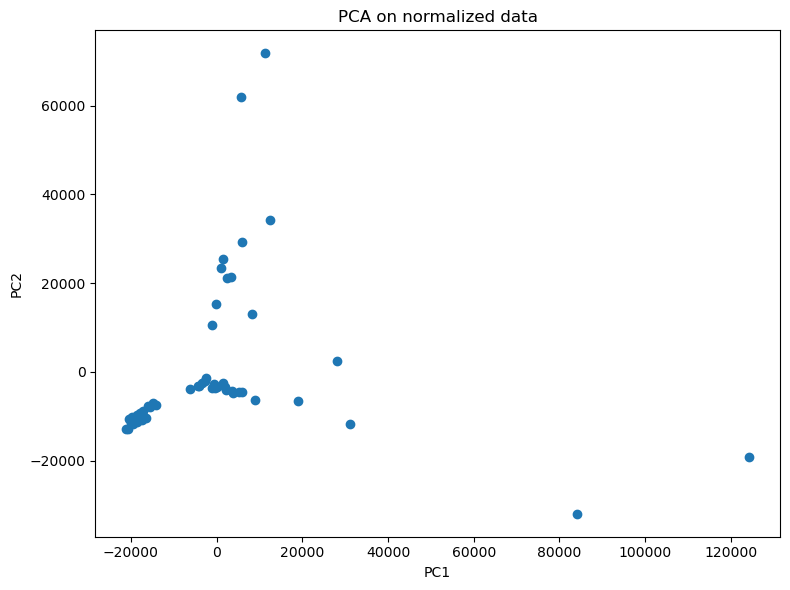

In [ ]:
# 1d: PCA without log transform
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(cpm_df.T)
plt.figure(figsize=(8,6))
plt.scatter(pca_scores[:,0], pca_scores[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on normalized data")
plt.tight_layout()
plt.show()

# cant see three clear clusters, but some indication of clustering

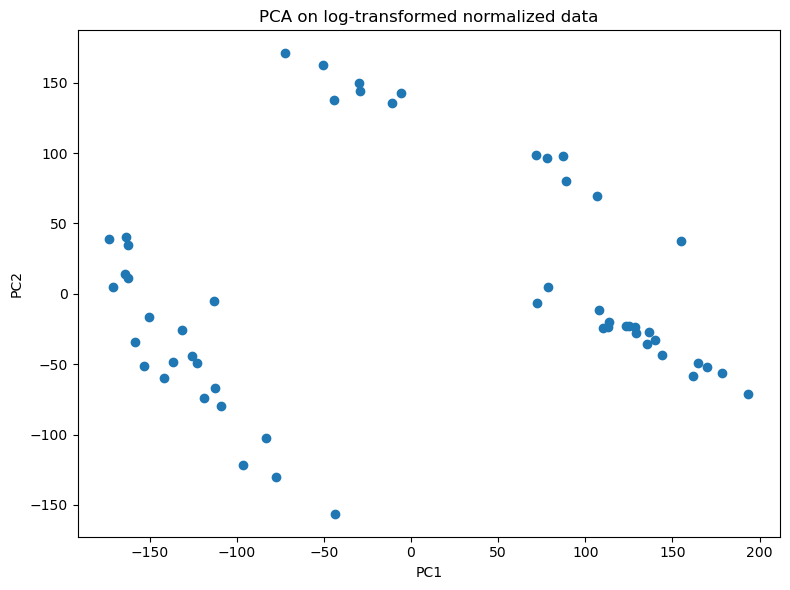

In [ ]:
# 1e: Log transform
log_cpm_df = np.log2(cpm_df+1)
pca_log = PCA(n_components=2)
pca_log_scores = pca_log.fit_transform(log_cpm_df.T)
plt.figure(figsize=(8,6))
plt.scatter(pca_log_scores[:,0], pca_log_scores[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on log-transformed normalized data")
plt.tight_layout()
plt.show()

# way better
# We will proceed with log-transformed data

c:\Users\julso\anaconda3\envs\analysis_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


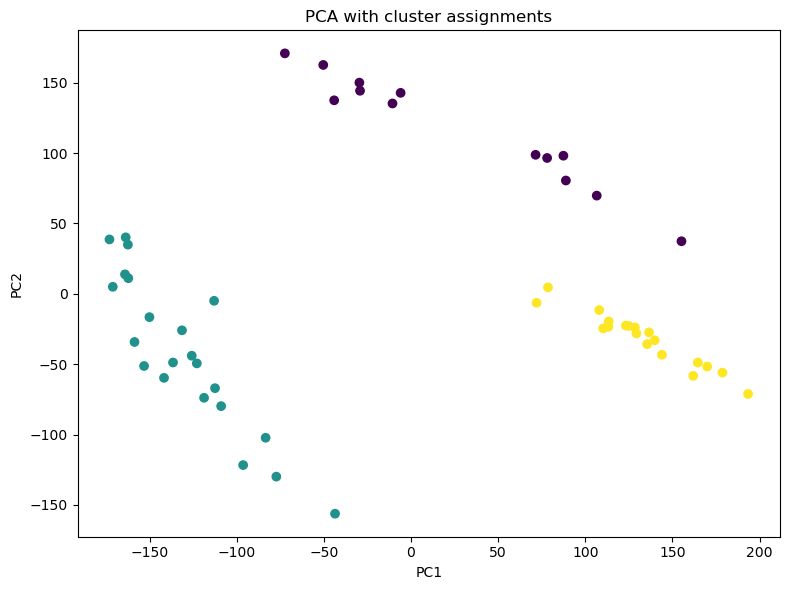

In [ ]:
# 1f: Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(log_cpm_df.T)
plt.figure(figsize=(8,6))
plt.scatter(pca_log_scores[:,0], pca_log_scores[:,1], c=cluster_labels, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA with cluster assignments")
plt.tight_layout()
plt.show()

cluster_dict = {0:'Cluster_1', 1:'Cluster_2', 2:'Cluster_3'}
clusters = pd.Series(cluster_labels, index=log_cpm_df.columns).map(cluster_dict)

# Sort clusters by size
cluster_sizes = clusters.value_counts()
sorted_clusters = cluster_sizes.sort_values(ascending=False).index
sorted_cluster_map = {old: f"Cluster_{i+1}" for i, old in enumerate(sorted_clusters)}
clusters = clusters.map(sorted_cluster_map)

In [ ]:
# 2a: Differential Expression Analysis
def differential_expression(log_data, clusters, focus_cluster):
    focus_samples = clusters[clusters == focus_cluster].index
    other_samples = clusters[clusters != focus_cluster].index

    focus_mat = log_data[focus_samples]
    other_mat = log_data[other_samples]

    # 2a: Compute p-values from t-test
    pvals = []
    for gene in log_data.index:
        t_stat, p_val = ttest_ind(focus_mat.loc[gene], other_mat.loc[gene], equal_var=False)
        pvals.append(p_val)
    pvals = np.array(pvals)

    # 2b: FDR correction
    _, fdr_corrected, _, _ = multipletests(pvals, method='fdr_bh')

    # 2c: Compute means
    mean_focus = focus_mat.mean(axis=1)
    mean_other = other_mat.mean(axis=1)

    # 2d: log2 fold change (log_data already log-transformed)
    log2_fold_change = mean_focus - mean_other

    res_df = pd.DataFrame(index=log_data.index, data={
        'p-value': pvals,
        'fdr': fdr_corrected,
        'mean': mean_focus,
        'mean_other': mean_other,
        'log2_fold_change': log2_fold_change
    })
    return res_df


# Perform DE for each cluster
de_results = {}
for c in cluster_dict.values():
    num_genes_in_cluster = (clusters == c).sum()  # Count the number of samples in the cluster
    de_results[c] = differential_expression(log_cpm_df, clusters, c)
    num_significant_genes = (de_results[c]['p-value'] < 0.05).sum()
    print(f"{c}: {num_genes_in_cluster} genes in cluster, {num_significant_genes} genes with p < 0.05")

# 2e: Filter DEGs (FDR<0.05 & log2FC>1)
filtered_degs = {}
for c in cluster_dict.values():
    df_deg = de_results[c]
    sig = df_deg[(df_deg['fdr'] < 0.05) & (df_deg['log2_fold_change'] > 1)]
    sig_sorted = sig.sort_values('log2_fold_change', ascending=False)
    filtered_degs[c] = sig_sorted
    print(f"{c}: DEGs with FDR<0.05 & log2FC>1: {sig_sorted.shape[0]}")

Cluster_1: 13 genes in cluster, 3543 genes with p < 0.05
Cluster_2: 22 genes in cluster, 6373 genes with p < 0.05
Cluster_3: 19 genes in cluster, 6232 genes with p < 0.05
Cluster_1: DEGs with FDR<0.05 & log2FC>1: 401
Cluster_2: DEGs with FDR<0.05 & log2FC>1: 1023
Cluster_3: DEGs with FDR<0.05 & log2FC>1: 3171


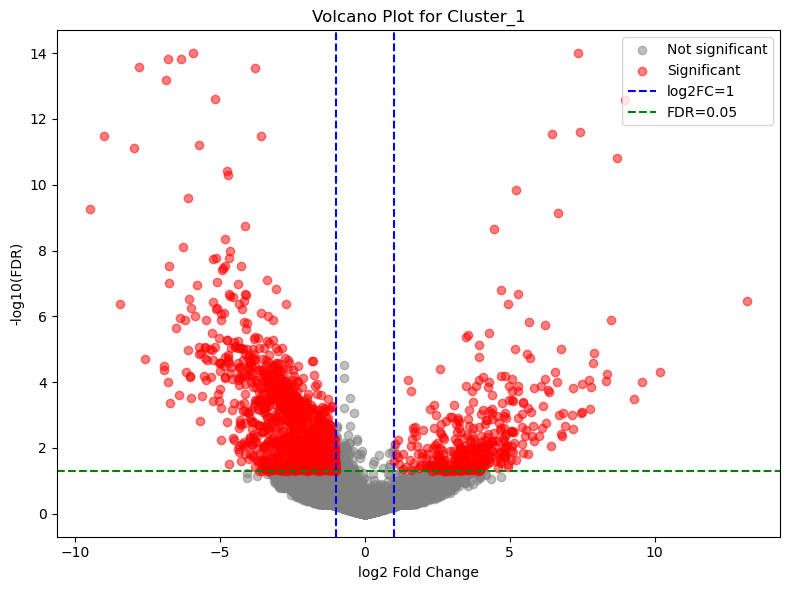

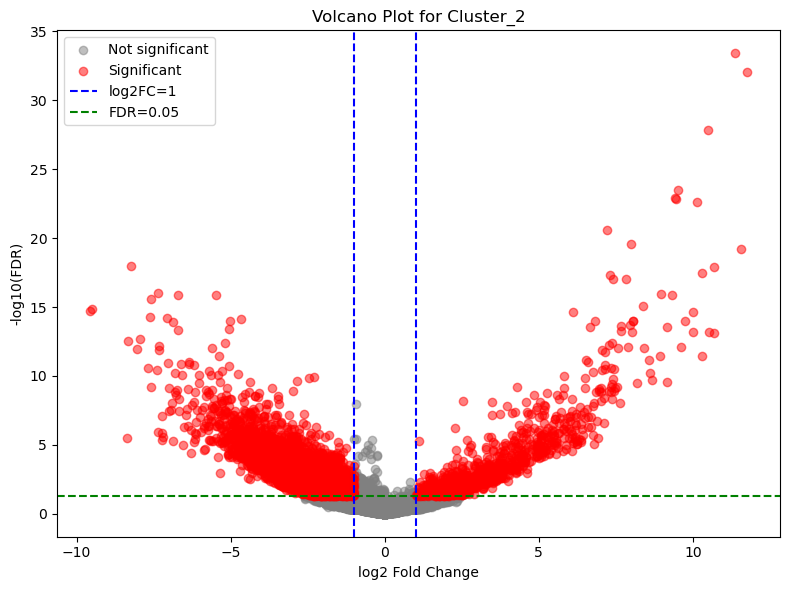

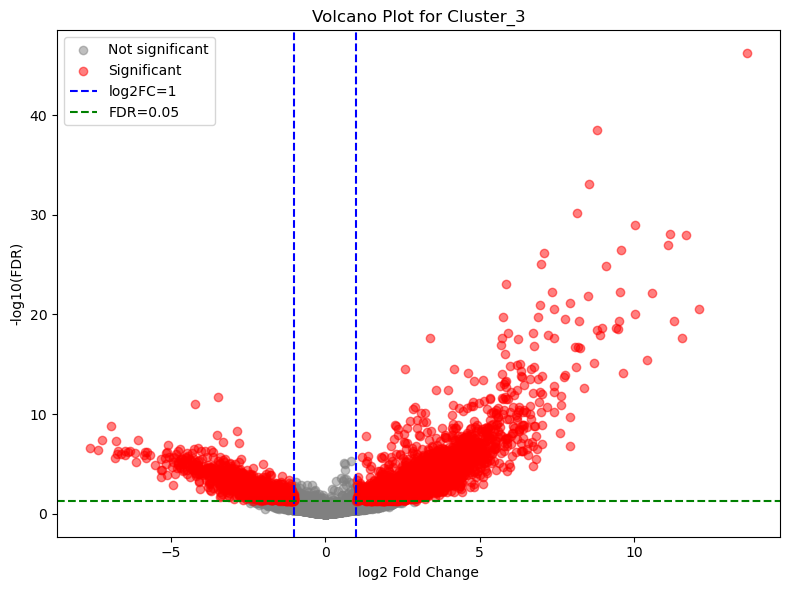

In [45]:
# 2f: Volcano plot
def plot_volcano(res, title):
    plt.figure(figsize=(8, 6))

    x = res['log2_fold_change']
    y = -np.log10(res['fdr'])

    # Define thresholds for significance
    is_significant = (res['fdr'] < 0.05) & (abs(res['log2_fold_change']) > 1)

    # Plot non-significant points
    plt.scatter(x[~is_significant], y[~is_significant], c='grey', alpha=0.5, label='Not significant')

    # Plot significant points
    plt.scatter(x[is_significant], y[is_significant], c='red', alpha=0.5, label='Significant')

    # Add threshold lines
    plt.axvline(x=1, color='blue', linestyle='--', label='log2FC=1')
    plt.axvline(x=-1, color='blue', linestyle='--')  # Negative fold change threshold
    plt.axhline(y=-np.log10(0.05), color='green', linestyle='--', label='FDR=0.05')

    # Labels and title
    plt.xlabel("log2 Fold Change")
    plt.ylabel("-log10(FDR)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_volcano(de_results['Cluster_1'], "Volcano Plot for Cluster_1")
plot_volcano(de_results['Cluster_2'], "Volcano Plot for Cluster_2")
plot_volcano(de_results['Cluster_3'], "Volcano Plot for Cluster_3")

C:\Users\julso\AppData\Local\Temp\ipykernel_355932\1414980570.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=cluster_order)


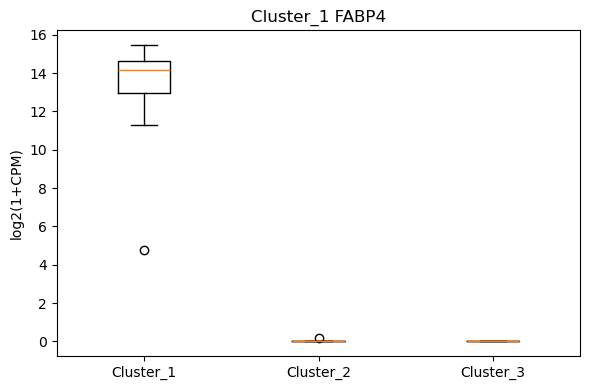

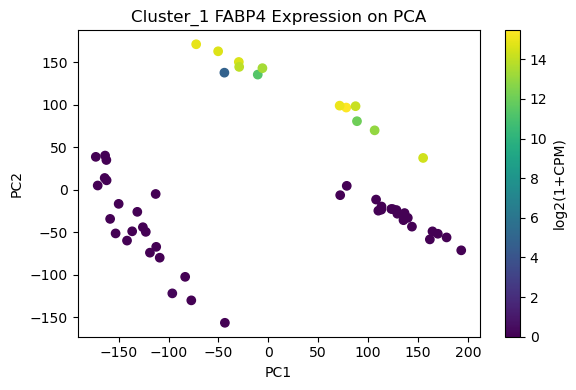

C:\Users\julso\AppData\Local\Temp\ipykernel_355932\1414980570.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=cluster_order)


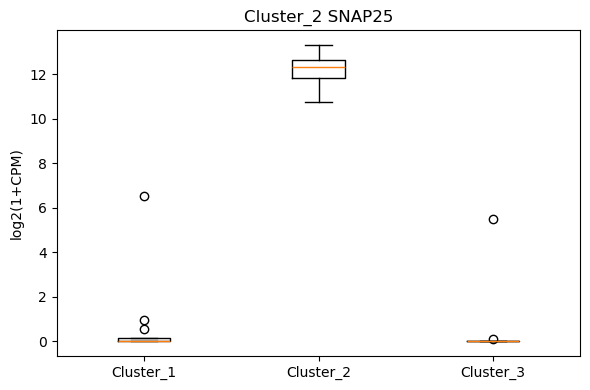

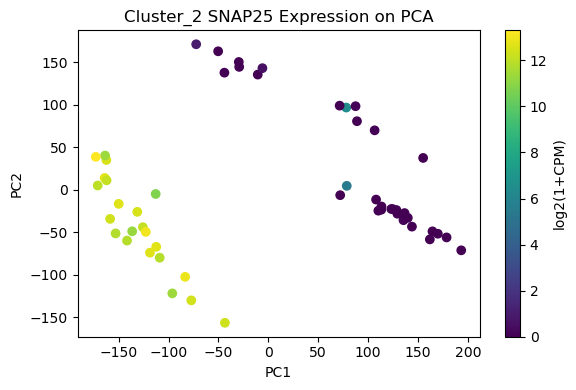

C:\Users\julso\AppData\Local\Temp\ipykernel_355932\1414980570.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=cluster_order)


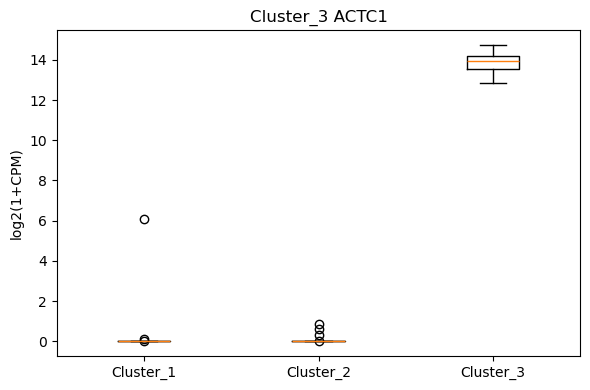

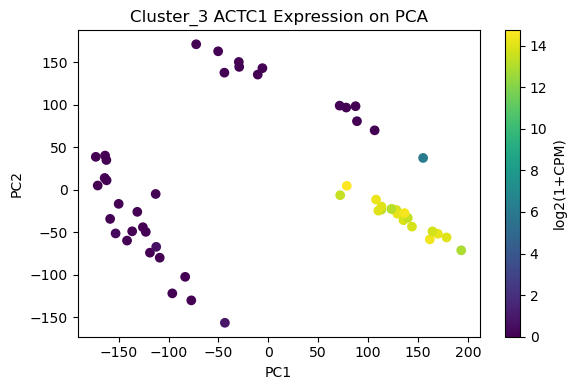

In [ ]:
# 3a: Top marker genes
# Map annotations from Ensembl IDs to gene names
annot_map = dict(zip(gene_annot['Ensembl IDs'], gene_annot['gene_name']))

def annotate_results(res):
    """
    Add 'gene_name' column to the result DataFrame by mapping Ensembl IDs.
    """
    res = res.copy()
    res['gene_name'] = res.index.map(annot_map)
    return res

# Annotate all filtered DEGs
for c in filtered_degs:
    filtered_degs[c] = annotate_results(filtered_degs[c])

# 2b: Pick top marker genes for each cluster
top_markers = {}
for c in filtered_degs:
    if filtered_degs[c].shape[0] > 0:
        # Pick the top gene with a valid annotation
        top_genes = filtered_degs[c].dropna(subset=['gene_name'])
        if top_genes.shape[0] > 0:
            top_markers[c] = top_genes.iloc[0]['gene_name']

# Reverse annotation mapping for gene_name -> Ensembl ID
rev_map = {v: k for k, v in annot_map.items() if pd.notnull(v)}

def plot_gene_expression(gene_name, clusters, log_data, pca_scores, title_prefix=""):
    """
    Plot the expression of a given gene as a boxplot and on PCA with gradient coloring.
    """
    # Map gene_name back to Ensembl ID if applicable
    gene_id = rev_map.get(gene_name, gene_name)  # Default to gene_name if not found in rev_map

    # Extract gene expression
    gene_expr = log_data.loc[gene_id]

    # Boxplot
    plt.figure(figsize=(6, 4))
    cluster_order = sorted(clusters.unique())
    data_box = [gene_expr[clusters == cl] for cl in cluster_order]
    plt.boxplot(data_box, labels=cluster_order)
    plt.title(f"{title_prefix} {gene_name}")
    plt.ylabel("log2(1+CPM)")
    plt.tight_layout()
    plt.show()

    # PCA gradient
    plt.figure(figsize=(6, 4))
    sc = plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c=gene_expr.values, cmap='viridis')
    plt.colorbar(sc, label='log2(1+CPM)')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{title_prefix} {gene_name} Expression on PCA")
    plt.tight_layout()
    plt.show()

# Plot top marker genes for each cluster
for c in cluster_dict.values():
    gname = top_markers.get(c)
    if gname:  # Plot only if a top marker exists
        plot_gene_expression(gname, clusters, log_cpm_df, pca_log_scores, title_prefix=c)


In [ ]:
# 3c: Identifying cell types is done externally using Enrichr.

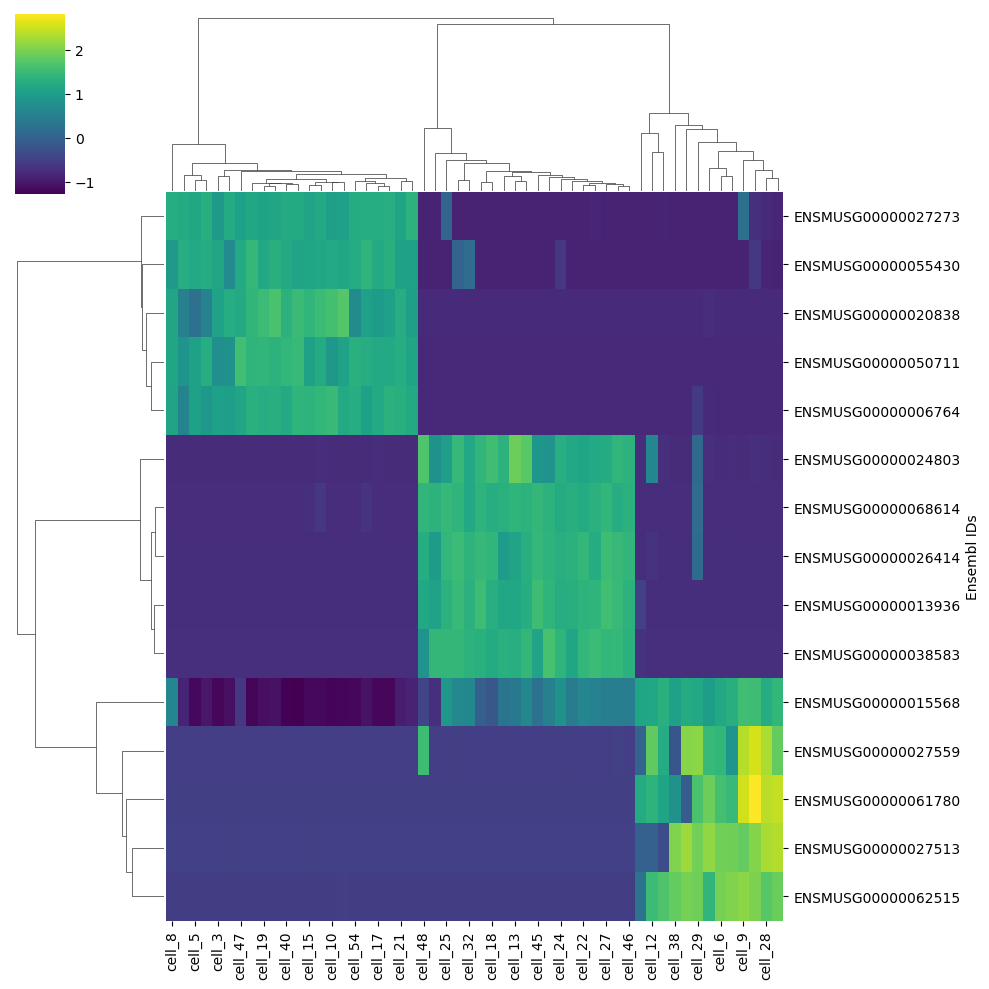

In [ ]:
# 3d: Clustered heatmap of top 5 marker genes for each cluster
top5_genes = []
for c in filtered_degs:
    top5 = filtered_degs[c].head(5).index.to_list()
    top5_genes.extend(top5)
top5_genes = list(set(top5_genes))

if len(top5_genes) > 0:
    subset_data = log_cpm_df.loc[top5_genes]
    sns.clustermap(subset_data, cmap='viridis', z_score=0)
    plt.show()

# Save plots as needed for the PDF summary outside the script